In [1]:
import pandas as pd
pd.set_option('display.max_columns',100)
import numpy as np
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

# Plotting packs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#NLP packs
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from textblob import TextBlob , Word
import re 
import string
import spacy
from tqdm.notebook import tqdm

##Wordcloud Modules
from wordcloud import WordCloud , STOPWORDS

#Machine learning Packs
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier 
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Amazon Review NLP Analysis

In [2]:
import os
import pandas as pd

url = r"http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz"
df = pd.read_json(url, compression='gzip', lines=True)

display(df.head(10))

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"
5,A2JXAZZI9PHK9Z,0594451647,"Billy G. Noland ""Bill Noland""","[3, 3]",I am using this with a Nook HD+. It works as d...,5,HDMI Nook adapter cable,1388707200,"01 3, 2014"
6,A2P5U7BDKKT7FW,0594451647,Christian,"[0, 0]",The cable is very wobbly and sometimes disconn...,2,Cheap proprietary scam,1398556800,"04 27, 2014"
7,AAZ084UMH8VZ2,0594451647,"D. L. Brown ""A Knower Of Good Things""","[0, 0]",This adaptor is real easy to setup and use rig...,5,A Perfdect Nook HD+ hook up,1399161600,"05 4, 2014"
8,AEZ3CR6BKIROJ,0594451647,Mark Dietter,"[0, 0]",This adapter easily connects my Nook HD 7&#34;...,4,A nice easy to use accessory.,1405036800,"07 11, 2014"
9,A3BY5KCNQZXV5U,0594451647,Matenai,"[3, 3]",This product really works great but I found th...,5,This works great but read the details...,1390176000,"01 20, 2014"


In [3]:
df = df[['reviewText', 'overall']]
df.head()

,reviewText,overall
0,We got this GPS for my husband who is an (OTR)...,5
1,"I'm a professional OTR truck driver, and I bou...",1
2,"Well, what can I say. I've had this unit in m...",3
3,"Not going to write a long review, even thought...",2
4,I've had mine for a year and here's what we go...,1


## Data Cleaning

In [4]:
df['reviewText']=df['reviewText'].str.lower().str.replace('[^\w\s]','').str.replace('\d+','').str.replace('\n',' ').replace('\r','')

In [5]:
df.loc[df.overall<=5 ,'sentiment'] = 2 # positive
df.loc[df.overall==3 ,'sentiment'] = 1 # notr
df.loc[df.overall< 3 ,'sentiment'] = 0 # negative
df.loc[:, 'sentiment'] = df.sentiment.astype(int)

df.head()

,reviewText,overall,sentiment
0,we got this gps for my husband who is an otr o...,5,2
1,im a professional otr truck driver and i bough...,1,0
2,well what can i say ive had this unit in my t...,3,1
3,not going to write a long review even thought ...,2,0
4,ive had mine for a year and heres what we got ...,1,0


## Training & Prediction


In [6]:
def nlp_analysis(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)
    
    vectorizers=[CountVectorizer()]
    ngrams = [(1,2)]
    
    classifiers=[MultinomialNB(), XGBClassifier()]
    
    col_names = ['Classifier','Methods', 'N-Grams','Accuracy','Precision','Recall', 'F1']
    df_nlp = pd.DataFrame(columns=col_names)   
    
    for i in vectorizers:
        vec=i
        vec_name = i.__class__.__name__
        vec.stop_words='english'
        
        for j in ngrams:
            vec.ngram_range=j
            X_train_dtm = vec.fit_transform(X_train)
            X_test_dtm = vec.transform(X_test)
            
            for k in classifiers:
                pred = k.fit(X_train_dtm, y_train).predict(X_test_dtm)
                clas_name = k.__class__.__name__
                
                accuracy = accuracy_score(y_test, pred)
                precision = precision_score(y_test, pred, average='weighted')
                f1 = f1_score(y_test, pred, average='weighted')
                recall = recall_score(y_test, pred, average='weighted')
                
                df_entry = pd.DataFrame([[clas_name, vec_name, j, accuracy*100, precision*100, recall*100, f1*100]], 
                                        columns=col_names)
                df_nlp=df_nlp.append(df_entry)
    return df_nlp

In [7]:
nlp_analysis(df.reviewText, df.sentiment)

,Classifier,Methods,N-Grams,Accuracy,Precision,Recall,F1
0,MultinomialNB,CountVectorizer,"(1, 2)",82.376464,80.149612,82.376464,76.069805
0,XGBClassifier,CountVectorizer,"(1, 2)",84.283592,80.655034,84.283592,80.202528


## WordCloud

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
stopwords = nltk.corpus.stopwords.words('english')

In [10]:
def wc(data,bgcolor): # word cloud
    plt.figure(figsize=(10,10))
    wc=WordCloud(background_color=bgcolor,max_words=100, min_word_length=3, stopwords=stopwords)
    wc.generate(" ".join(data)) # tum kelimeleri birlestirip tek 1 string haline getirir
    plt.imshow(wc)
    plt.axis("off")

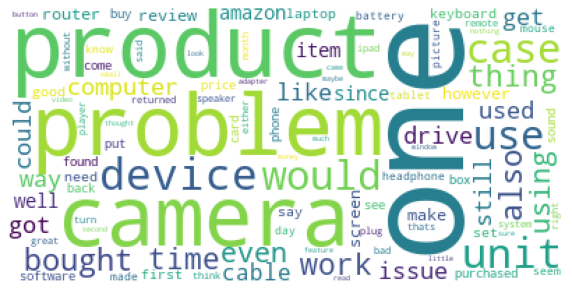

In [11]:
wc(df[df.sentiment==0].reviewText,"white") # Notr

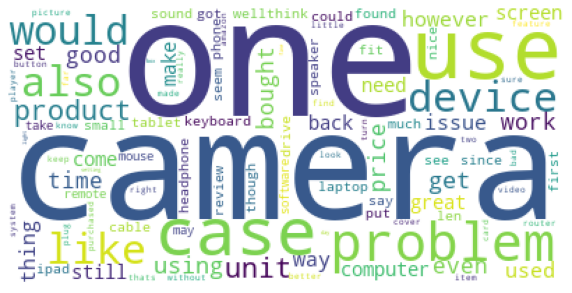

In [12]:
wc(df[df.sentiment==1].reviewText,"white") # Negative

In [13]:
wc(df[df.sentiment==2].reviewText,"white") # Positive